## Cloud Computing for Distributed Big Data Applications Option : Centralized Machine Learning

#### The goal of this lab is to get you familiar with the basics of machine learning.

#### You will be asked to train an ML model for a relatively simple dataset 'MNIST' using the torch package

In [1]:
## import the package

import torch

112800


In [ ]:
from IPython import display
from base64 import b64decode
display.Image(b64decode(base64_data))

NameError: ignored

See the documentation
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 

#### Below is a potentially good model architecture to start with. 
![](model_architecture.jpeg)


In [2]:
## create the model 
from torch import nn

input_size = 28*28
output_size = 27


class EmnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64*14*14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256*7*7

            nn.Flatten(),
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 27)
        )
        
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, label = batch
        labels = to_device(torch.tensor([x-1 for x in label]), device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, label = batch
        labels = to_device(torch.tensor([x-1 for x in label]), device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



See Documentation https://pytorch.org/vision/stable/datasets.html

##### The MNIST dataset is  a database of handwritten digits. it has a training set of 60,000 examples, and a test set of 10,000 examples.  The digits have been size-normalized and centered in a fixed-size image.

##### In the next two cells, you are asked to first : load both the training and test set of MNIST while appllying  the appropriate transformations & second : take a closer look at the dataset by checking the images' shape, the label & displaying some images ( Matplolib library is an option for that)

In [3]:
## Prepare Dataset
from torchvision import datasets, transforms

transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.EMNIST(root='data', split = 'letters', train = True, transform = transform, download = True)
test_dataset = datasets.EMNIST(root='data', split = 'letters', train= False, transform = transform)

def get_dataset():  
    """ Returns train and test datasets for MNIST
        Data is normalized using (0.1307,), (0.3081,)
    """
    
    return train_dataset, test_dataset
  
len(train_dataset)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


124800

In [4]:
#dataloader

from torch.utils.data import DataLoader

batch_size = 128

train_load = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_load = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

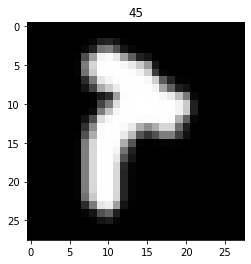

In [ ]:
## Display Images 
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0], cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

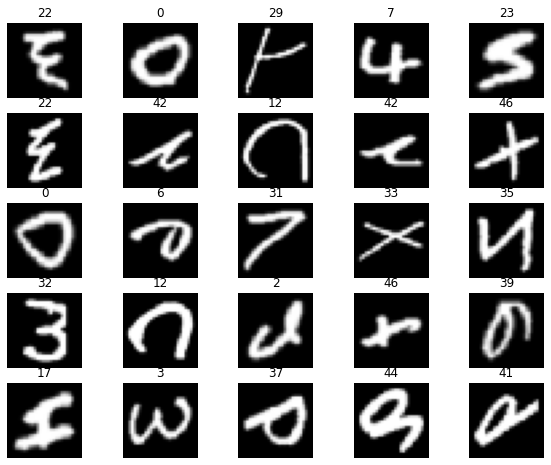

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
#GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [6]:
train_load = DeviceDataLoader(train_load, device)
val_load = DeviceDataLoader(val_load, device)

In [7]:
model = EmnistModel()
to_device(model, device)

EmnistModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=12544, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=27, bias=True)
  )
)

##### Here you have to implement the train function of your model. 

##### A test function is provided for the evaluation of the model.


In [19]:
def train(epoch, net, optimizer, criterion, trainloader):
    net.train()
    for batch_idx, (images, labels) in enumerate(trainloader):
        ## Initialize the model
        ##  classify the images using the model
        ## compute the loss between the real labels and predicted labels
        ## backpropagate the loss
        ## update the optimizer
        images, labels = images.to(device) , labels.to(device)
        net.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ## display the loss & epoch, every 10 batchs for instance.
        #print("Loss:"+ str(loss.item()) + ", Epoch:" + str(epoch) + ", Batch number "+ str(batch_idx))
def test(model, criterion, testloader):
    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    for batch_idx, (images, labels) in enumerate(testloader):
        #images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct / total
    return accuracy*100, loss

See Documentation : https://pytorch.org/docs/stable/generated/torch.optim.SGD.html and https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
from time import time
from torch.utils.data import DataLoader
import torch.optim as optim

def main():
    
    ## You can play with these parameters & observe how they effect the training process.
    learning_rate = 0.001
    batch_size = 64 
    epochs = 5 
    
    
    ## instantiate your model
    net = EmnistModel()
    net.to(device)
    ## create two dataloaders (train & test) to load data into batches

    trainloader = DataLoader(train_dataset, batch_size, shuffle = True)

    testloader = DataLoader(test_dataset, batch_size, shuffle = True)

    train_loader = DeviceDataLoader(trainloader, device)
    test_loader = DeviceDataLoader(testloader, device)
    ## instantiate an optimizer for you model, as well as a criterion/loss function - SGD
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())
    
    # Evaluating the model before any training steps is a good practice
    accuracy, loss = test(net, criterion, test_loader)
    print('Before training :',f'Accuracy: {accuracy}', f'Loss: {loss}' )
    
    time0 = time() 
    for epoch in range(epochs):
        train(epoch, net, optimizer, criterion, train_loader)
        accuracy, loss = test(net, criterion, test_loader)
        print(f'Epoch :{epoch}',f'Accuracy: {accuracy}', f'Loss: {loss}' )
    print(f'Training Time (minutes) :{(time()-time0) / 60}')

In [ ]:
main()

Before training : Accuracy: 3.817307692307692 Loss: 1070.5490567684174
Loss:3.299219846725464, Epoch:0, Batch number 0
Loss:3.304894208908081, Epoch:0, Batch number 1
Loss:3.2875916957855225, Epoch:0, Batch number 2
Loss:3.2828304767608643, Epoch:0, Batch number 3
Loss:3.2469780445098877, Epoch:0, Batch number 4
Loss:3.1939358711242676, Epoch:0, Batch number 5
Loss:3.225059986114502, Epoch:0, Batch number 6
Loss:3.1818392276763916, Epoch:0, Batch number 7
Loss:3.120201349258423, Epoch:0, Batch number 8
Loss:3.022217273712158, Epoch:0, Batch number 9
Loss:2.9164206981658936, Epoch:0, Batch number 10
Loss:2.719472646713257, Epoch:0, Batch number 11
Loss:2.5306291580200195, Epoch:0, Batch number 12
Loss:2.3410611152648926, Epoch:0, Batch number 13
Loss:2.3856587409973145, Epoch:0, Batch number 14
Loss:2.1283600330352783, Epoch:0, Batch number 15
Loss:2.1580984592437744, Epoch:0, Batch number 16
Loss:2.2128746509552, Epoch:0, Batch number 17
Loss:1.8170918226242065, Epoch:0, Batch number 1

In [9]:
import torch
torch.cuda.is_available()

True

[[0.15889933 0.12144232 0.14014445 0.17996855 0.26012571 0.16794575
  0.15274504 0.14585389 0.19707153 0.26719777 0.14176413 0.13900579
  0.1776931  0.25675788 0.15144484 0.19340744 0.18649539 0.20423904
  0.25213028 0.22318198 0.16064716 0.12856712 0.17858317 0.22013824
  0.22323808 0.17716852]
 [0.13583953 0.19486976 0.17917616 0.19906453 0.17175404 0.24957051
  0.21314812 0.27772409 0.16614478 0.19192421 0.25688249 0.23246732
  0.1897714  0.18289058 0.31250935 0.20876722 0.15381319 0.19727424
  0.21152567 0.23333855 0.20265348 0.22350844 0.17475559 0.18005254
  0.20886505 0.17570289]
 [0.28096445 0.29559389 0.16722939 0.23881786 0.17761709 0.15510348
  0.15852689 0.176945   0.23143963 0.24503446 0.16941037 0.23154009
  0.1655153  0.2068195  0.18725474 0.24412946 0.20688013 0.18096198
  0.17088384 0.19011401 0.22348987 0.20558958 0.11671288 0.19012634
  0.18605793 0.15870001]
 [0.27242256 0.21286558 0.32166573 0.17752901 0.16865293 0.24124172
  0.19497196 0.16130922 0.25628575 0.1478

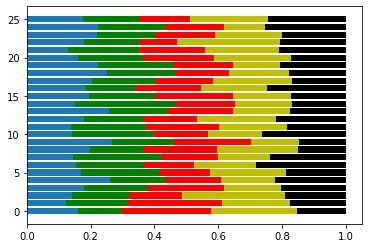

In [26]:
import numpy
import matplotlib.pyplot as plt

alpha = 20
nusers = 5
ndata = 26

diri = numpy.random.dirichlet([alpha]*nusers , ndata).transpose()

plt.barh(range(26), diri[0])
plt.barh(range(26), diri[1], left=diri[0], color='g')
plt.barh(range(26), diri[2], left=diri[0]+diri[1], color='r')
plt.barh(range(26), diri[3], left=diri[0]+diri[1]+diri[2], color='y')
plt.barh(range(26), diri[4], left=diri[0]+diri[1]+diri[2]+diri[3], color='black')

print(diri)

In [ ]:
print(diri[0,0]+diri[1,0]+diri[2,0]+diri[3,0]+diri[4,0])

1.0


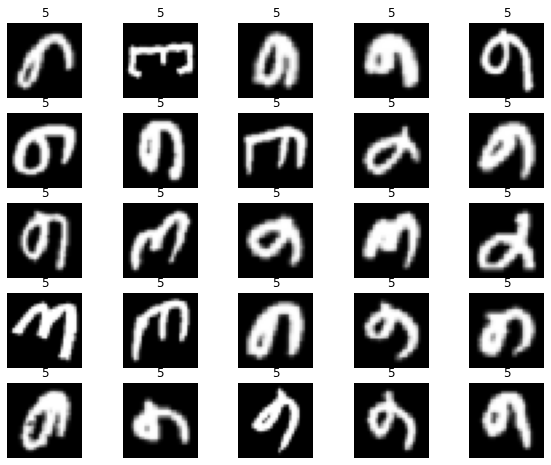

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

trainDict = {}
subsetDict = {}
labels = train_dataset.targets
numbersRg = list(range(0,25))
for i in numbersRg:
  trainDict['train{0}'.format(i)] = []

for j in numbersRg:
  for i in range(len(labels)):
    tensor = "tensor(" + str(j) + ")"
    if str(labels[i]) == tensor:
      trainDict['train{0}'.format(j)].append(i)

for i in numbersRg:
   subsetDict['subset{0}'.format(i)] = Subset(train_dataset, trainDict['train{0}'.format(i)])

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(subsetDict['subset5']), size=(1,)).item()
    img, label = subsetDict['subset5'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

[0, 1, 2, 3, 4]


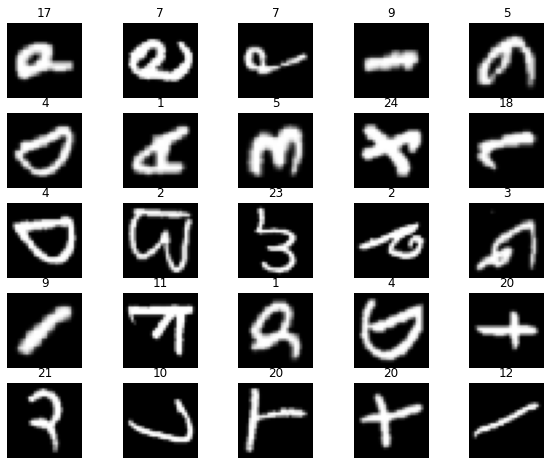

21444
24025
22628
23860
23088


In [36]:
from torch.utils.data import ConcatDataset

clientDict = {}
clientSetDict = {}
sizeDatasets = {}
sizeDatasetsClients = {}
subsetsNestDict = {}
labels = train_dataset.targets
numberClients = list(range(nusers))
print(numberClients)
for j in numberClients:
  clientDict['client{0}set'.format(j+1)] = []

for i in numbersRg:
  sizeDatasets['n{0}'.format(i)] = len(subsetDict['subset{0}'.format(i)])
  for j in numberClients:
    if j == 0:
      newRg = 0
      lastRg = 0
    sizeDatasetsClients['n' + str(i) + '_client' + str(j)] = int(diri[j,i] * sizeDatasets['n{0}'.format(i)])
    newRg += sizeDatasetsClients['n' + str(i) + '_client' + str(j)]
    diricSize = range(lastRg, newRg)
    #print(diricSize)
    lastRg = newRg + 1
    subsetsNestDict['client' + str(j) + '_set' + str(i)] = Subset(subsetDict['subset{0}'.format(i)], diricSize)
    clientDict['client{0}set'.format(j+1)].extend(subsetsNestDict['client' + str(j) + '_set' + str(i)])


figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(clientDict['client4set']), size=(1,)).item()
    img, label = clientDict['client4set'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(len(clientDict['client1set']))
print(len(clientDict['client2set']))
print(len(clientDict['client3set']))
print(len(clientDict['client4set']))
print(len(clientDict['client5set']))

In [41]:
#devices

deviceList = {}

for j in numberClients:
  deviceList['device{0}'.format(j+1)] = get_default_device()

deviceGlobal = get_default_device()

In [51]:
from time import time
from torch.utils.data import DataLoader
import torch.optim as optim

#Make a global model


def mainFL():
    
    ## You can play with these parameters & observe how they effect the training process.
    learning_rate = 0.001
    batch_size = 64 # It has to be lower due to a lower number of data
    epochs = 10 # Not very important after 5 in centralised, important for FL

    
    ## instantiate your nets a datasets
    net1 = EmnistModel()
    net1.to(deviceList['device1'])
    net2 = EmnistModel()
    net2.to(deviceList['device2'])
    net3 = EmnistModel()
    net3.to(deviceList['device3'])
    net4 = EmnistModel()
    net4.to(deviceList['device4'])
    net5 = EmnistModel()
    net5.to(deviceList['device5'])
    netGlobal = EmnistModel()
    netGlobal.to(deviceGlobal)
    netList = [net1, net2, net3, net4, net5]
    datasetList = [clientDict['client1set'], clientDict['client2set'], clientDict['client3set'], clientDict['client4set'], clientDict['client5set']]
    tupleData = list(zip(netList,datasetList))
    clients = [0,1,2,3,4]

    testloader = DataLoader(test_dataset, batch_size, num_workers = 2, shuffle = True, pin_memory=True)
         
    time0 = time()

    for epoch in range(epochs):
      net_dict = {}
      criterion = nn.CrossEntropyLoss()
      for index,(i,j) in enumerate(tupleData):          
          ## create dataloaders for each user (train) to load data into batches
          trainloader = DataLoader(j, batch_size, num_workers = 2, shuffle = True, pin_memory=True)
          
          ## Send data to GPU
          train_loader = DeviceDataLoader(trainloader, deviceList['device{0}'.format(index+1)])
          test_loader = DeviceDataLoader(testloader, deviceList['device{0}'.format(index+1)])
          ## instantiate an optimizer for you model, as well as a criterion/loss function - SGD         
          optimizer = optim.Adam(i.parameters(), lr= learning_rate)
    
          # Evaluating the model before any training steps is a good practice
          accuracy, loss = test(i, criterion, test_loader)
          print('Before training :',f'Accuracy: {accuracy}', f'Loss: {loss}',f'Client {index+1}' )
           
          train(epoch, i, optimizer, criterion, train_loader)
          accuracy, loss = test(i, criterion, test_loader)
          net_dict[index] = i
          print('After training :',f'Accuracy: {accuracy}', f'Loss: {loss}',f'Client {index+1}' )
  
      test_loader_global = DeviceDataLoader(testloader, deviceGlobal)
      netGlobal = aggregrate_models(net_dict, netGlobal, clients)
      for model, _ in tupleData:
        model.load_state_dict(netGlobal.state_dict())
      accuracy, loss = test(netGlobal, criterion, test_loader_global)
      print(f'Epoch: {epoch+1}',f'Accuracy: {accuracy}', f'Loss: {loss}')
    print('Training Time (minutes):' + str((time()-time0) / 60))

    accuracy, loss = test(netGlobal, criterion, test_loader_global)
    print(f'Accuracy: {accuracy}', f'Loss: {loss}', f'Learning Rate {learning_rate}')
    

In [44]:
def aggregrate_models(net_dict, netGlobal, clients): 
    update_state = {}
    first = True
    for k in clients:
        for key in net_dict[k].state_dict().keys():
            if first:
                update_state[key] = net_dict[k].state_dict()[key]
            else:
                update_state[key] += net_dict[k].state_dict()[key]
        first = False
    for key in update_state:
        update_state[key] = update_state[key] / len(clients)

    netGlobal.load_state_dict(update_state)
    return netGlobal

In [52]:
mainFL()

Before training : Accuracy: 3.8461538461538463 Loss: 1070.9840257167816 Client 1
After training : Accuracy: 82.38461538461539 Loss: 506.0436598062515 Client 1
Before training : Accuracy: 3.8461538461538463 Loss: 1071.0752549171448 Client 2
After training : Accuracy: 81.08653846153845 Loss: 535.4617659449577 Client 2
Before training : Accuracy: 3.8461538461538463 Loss: 1070.7932143211365 Client 3
After training : Accuracy: 82.42788461538461 Loss: 506.3175006210804 Client 3
Before training : Accuracy: 3.8461538461538463 Loss: 1071.606420993805 Client 4
After training : Accuracy: 82.19711538461539 Loss: 632.2406592071056 Client 4
Before training : Accuracy: 3.8461538461538463 Loss: 1070.7001214027405 Client 5
After training : Accuracy: 80.63942307692308 Loss: 491.03984984755516 Client 5
Epoch: 1 Accuracy: 3.8461538461538463 Loss: 1070.5067250728607
Before training : Accuracy: 3.8461538461538463 Loss: 1070.506716966629 Client 1
After training : Accuracy: 76.73076923076924 Loss: 869.1581445

In [ ]:
mainFL()

Before training : Accuracy: 11.24 Loss: 360.690372467041 Client 1
Epoch: 0 Accuracy: 82.13000000000001 Loss: 304.992103099823 Client 1
Epoch: 1 Accuracy: 84.61999999999999 Loss: 288.37187081575394 Client 1
Epoch: 2 Accuracy: 86.26 Loss: 270.81847101449966 Client 1
Epoch: 3 Accuracy: 86.67 Loss: 269.927990347147 Client 1
Epoch: 4 Accuracy: 87.16000000000001 Loss: 271.3692548274994 Client 1
Training Time Client 1(minutes):0.45500451723734536
Before training : Accuracy: 8.92 Loss: 362.83163142204285 Client 2
Epoch: 0 Accuracy: 82.67 Loss: 168.7133373916149 Client 2
Epoch: 1 Accuracy: 85.39999999999999 Loss: 178.9130053371191 Client 2
Epoch: 2 Accuracy: 86.99 Loss: 169.8560634702444 Client 2
Epoch: 3 Accuracy: 87.16000000000001 Loss: 162.81113712489605 Client 2
Epoch: 4 Accuracy: 87.3 Loss: 169.29479610919952 Client 2
Training Time Client 2(minutes):0.46853724320729573
Before training : Accuracy: 7.59 Loss: 363.7604441642761 Client 3
Epoch: 0 Accuracy: 73.11999999999999 Loss: 748.672041416